# Hierarchische Assoziationsregeln
In vielen Anwendungen lassen sich Taxonomien finden und für die Suche nach Assoziationsregeln verwenden. Eine Jacke ist beispielsweise Teil der Oberkleidung und diese wiederum Teil der (allgemeinen) Kleidung.

In [ ]:
from tui_dsmt.fpm import clothes
from tui_dsmt.fpm import Itemset, apriori

## Inhaltsverzeichnis
- [Motivation](#Motivation)
- [Definitionen](#Definitionen)
- [Beispiel](#Beispiel)
- [Basisalgorithmus für hierarchische Assoziationsregeln](#Basisalgorithmus-für-hierarchische-Assoziationsregeln)
- [Cumulate](#Cumulate)
- [Stratify](#Stratify)

## Motivation
Der nachfolgende Baum zeigt den Zusammenhang zwischen einer kleinen Auswahl von Bekleidungstypen.

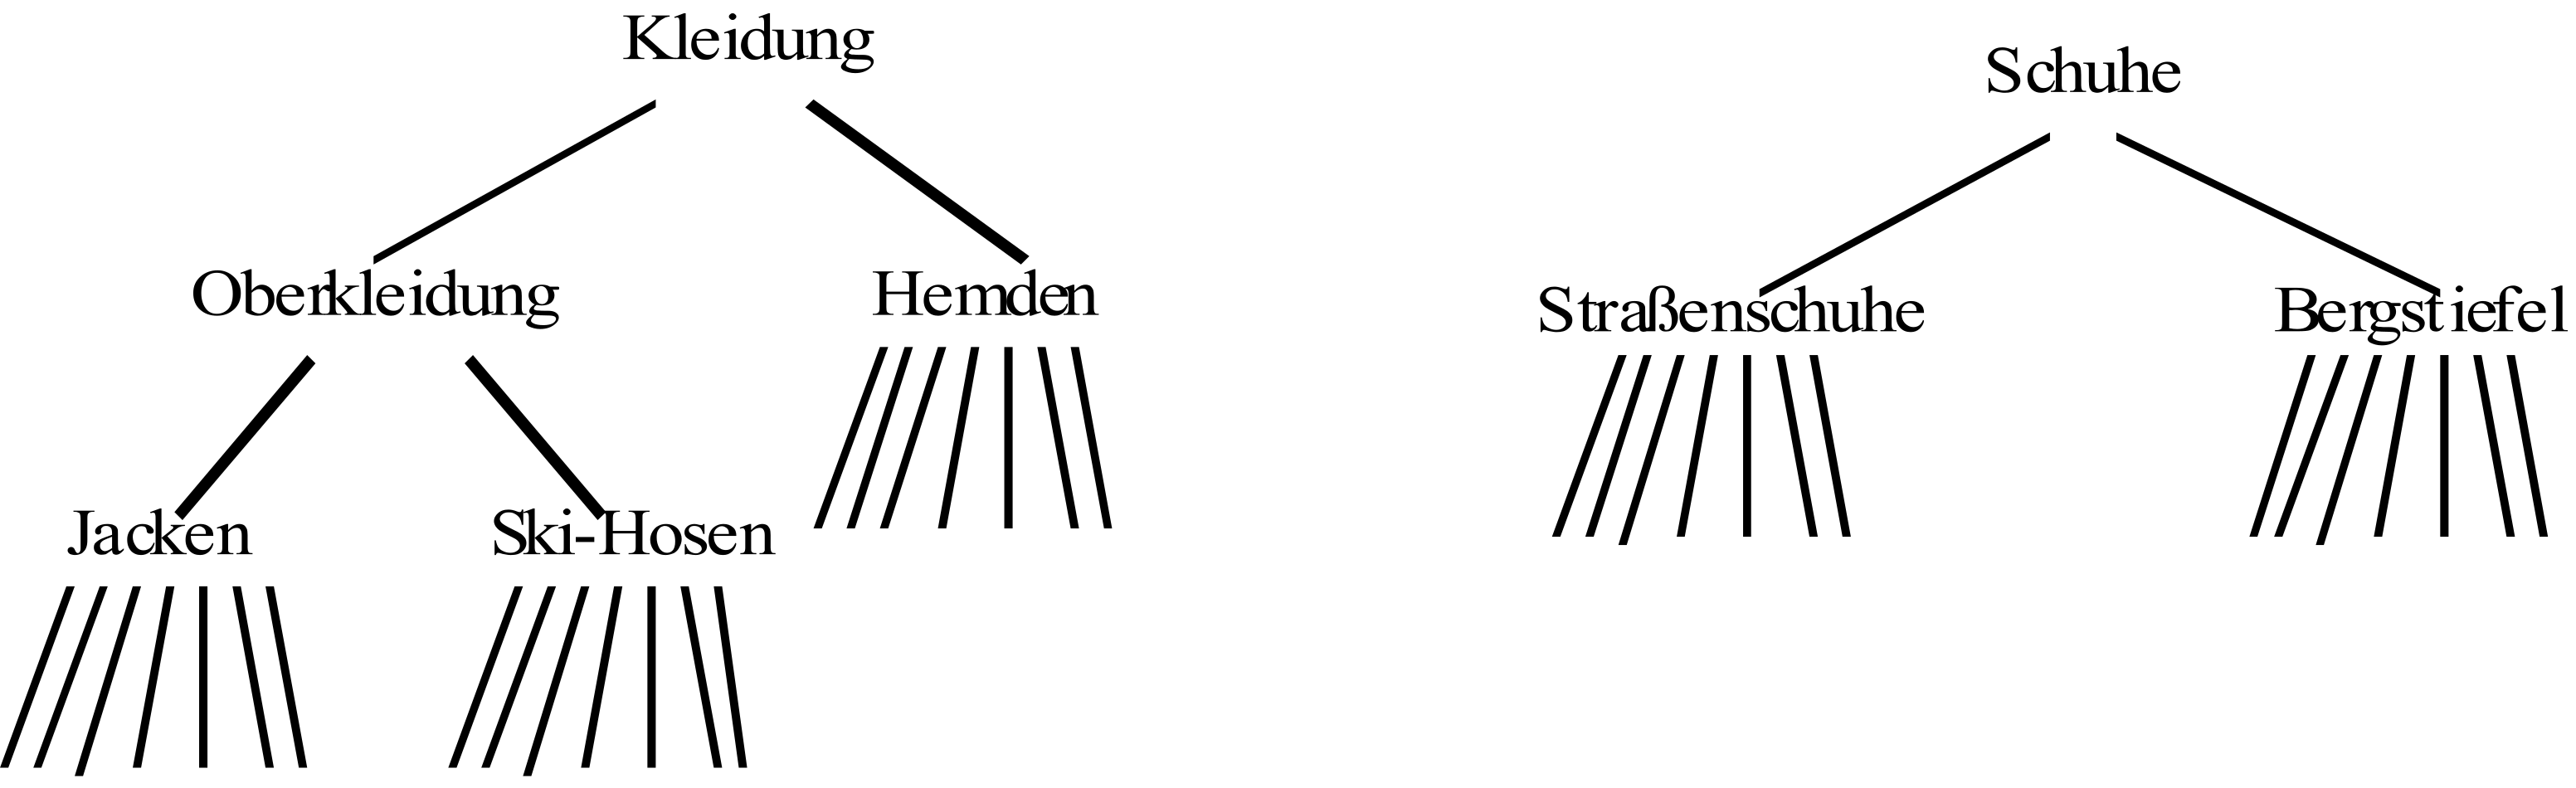

Um einen höheren Support der gefundenen Assoziationsregeln zu ermöglichen, sollen die Regeln auch innerhalb dieser Kategorien gesucht werden. So könnte z.B. gelten, dass
- $s(\text{Skihosen} \Rightarrow \text{Bergstiefel}) < min\_supp$
- $s(\text{Jacken} \Rightarrow \text{Bergstiefel}) < min\_supp$
- $s(\text{Oberkleidung} \Rightarrow \text{Bergstiefel}) \geq min\_supp$

## Definitionen
- $H$ ist ein gerichteter, azyklischer Graph über die Menge der Literale.
- Wenn eine Kante von einem Item $i$ zu einem Item $j$ existiert, dann heißt
    - $i$ eine **Verallgemeinerung** von $j$.
    - $i$ Vater oder **Vorgänger** von $j$.
    - $j$ Sohn, Kind oder **Nachfolger** von $i$.
- Wenn ein Pfad von $i$ zu einem Item $j$ existiert, dann heißt
    - $i$ **Vorfahre** von $j$.
    - $j$ **Nachfahre** von $i$.

## Beispiel
Eine Transaktionsdatenbank enthält einige Verkäufe eines Bekleidungsgeschäfts.

In [ ]:
clothes

Dabei zählen Hemd, Jacke und Ski-Hose zu Kleidung, während Bergstiefel und Straßenschuhe den Schuhen zugeordnet werden.

Daraus ergibt sich dann beispielsweise:

| Itemset / Assoziationsregel                          | Support | Konfidenz |
| ---------------------------------------------------- | ------- | --------- |
| $\{\text{Jacke}\}$                                   | $33\%$  |           |
| $\{\text{Jacke, Bergstiefel}\}$                      | $17\%$  |           |
| $\{\text{Oberkleidung}\}$                            | $67\%$  |           |
| $\{\text{Oberkleidung, Bergstiefel}\}$               | $33\%$  |           |
| $\text{Jacke} \Rightarrow \text{Bergstiefel}$        | $17\%$  | $50\%$    |
| $\text{Oberkleidung} \Rightarrow \text{Bergstiefel}$ | $33\%$  | $67\%$    |
| $\text{Bergstiefel} \Rightarrow \text{Jacke}$        | $17\%$  | $50\%$    |
| $\text{Bergstiefel} \Rightarrow \text{Oberkleidung}$ | $33\%$  | $100\%$   |

## Basisalgorithmus für hierarchische Assoziationsregeln
Für den Basisalgorithmus ist ein effizienter Zugriff auf die Vorfahren eines jeden Items notwendig. In Python kann das beispielsweise über ein Dictionary gelöst werden:

In [ ]:
ancestors = {
    'Hemd': ['Kleidung'],
    'Jacke': ['Oberkleidung', 'Kleidung'],
    'Ski-Hose': ['Oberkleidung', 'Kleidung'],
    'Bergstiefel': ['Schuhe'],
    'Straßenschuhe': ['Schuhe'],
    'Oberkleidung': ['Kleidung']
}

Das einfachste Vorgehen besteht nun darin, alle Vorfahren jedes einzelnen Items in die Transaktionen einzufügen.

In [ ]:
clothes_with_ancestors = clothes.map(lambda transaction: transaction + [ancestor for item in transaction for ancestor in ancestors[item]])
clothes_with_ancestors

Während der Apriori-Algorithmus mit einem minimalen Support von $0.2$ keine Itemsets mit einer Mindestgröße von zwei in der ursprünglichen Datenbank findet...

In [ ]:
apriori(clothes, min_supp=0.2)

... werden in der modifizierten Datenbank unter den gleichen Bedingungen mehrere häufige Itemsets gefunden.

In [ ]:
apriori(clothes_with_ancestors, min_supp=0.2)

Statt alle Vorfahren direkt in eine modifizierte Datenbank einzufügen, kann natürlich auch während des Algorithmus auf die Datenstruktur mit den Vorfahren zugegriffen werden. Somit müsste keine aufgeblähte Transaktionsdatenbank zwischengespeichert werden.

## Cumulate
Im Ergebnis der Transaktionsdatenbank mit eingefügten Vorfahren sind häufige Itemsets mit redundanten Items vorhanden. Da nach der vorgegebenen Taxonomie ein Bergstiefel ein Schuh ist, entspricht der Support des häufigen Itemsets $(\text{Bergstiefel}, \text{Schuhe})$ dem Support von $(\text{Bergstiefel})$.

In [ ]:
Itemset('Bergstiefel', 'Schuhe').count_in(clothes_with_ancestors)

In [ ]:
Itemset('Bergstiefel').count_in(clothes_with_ancestors)

Dem Monotonie-Kriterium folgend gilt außerdem, dass falls $(\text{Bergstiefel}, \text{Oberkleidung}, \text{Schuhe})$ häufig ist, auch $(\text{Bergstiefel}, \text{Oberkleidung})$ und $(\text{Oberkleidung}, \text{Schuhe})$ häufig sind. Es ist daher nicht notwendig ein Itemset aufzunehmen, das ein Item und mindestens einen seiner Vorfahren gleichzeitig enthält.

In [ ]:
for frequent_itemset in apriori(clothes_with_ancestors, min_supp=0.2):
    contains_ancestor = False
    for item in frequent_itemset:
        for ancestor in ancestors.get(item, ()):
            if ancestor in frequent_itemset:
                contains_ancestor = True

    if not contains_ancestor:
        print(frequent_itemset)

Wird diese Optimierung in jedem Schritt des Apriori-Algorithmus angewandt, kann damit die Zahl der Kandidaten verringert und damit auch die Laufzeit gesenkt werden.

## Stratify
Der Support eines Itemsets, das einen Vorfahren enthält, begrenzt den Support der Menge, die ein Kind enthält. Es gilt also zum Beispiel $\sigma(\text{Kleidung}, \text{Schuhe}) \geq \sigma(\text{Oberkleidung}, \text{Schuhe}) \geq \sigma(\text{Jacke}, \text{Schuhe})$.

Der Apriori-Algorithmus kann mit diesem Wissen auf eine weitere Weise beschleunigt werden. Wenn der Support für ein Itemset, das einen Vorfahren enthält, den minimalen Support nicht erfüllt, muss für ein Itemset, das eines der Kinder enthält, nicht erst der Support bestimmt werden.